In [4]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [5]:
class Value :
    def __init__(self, data, _children = (), _op = '', label = '') :
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) :
        return f"Value (data = {self.data})"

    def __add__ (self, other) :
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__ (self, other) :
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __neg__(self) :
        return self * (-1.0)

    def __sub__(self, other) :
        return self + (-other)

    def __truediv__(self, other) :
        return self * other ** (-1)

    def __rmul__(self, other) : # Check if self * other not possible, then do other * self
        return self * other

    def exp(self) :
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def tanh(self) :
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), label = 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def sigmoid(self) :
        x = self.data
        t = 1 / (1 + math.exp(-x))
        out = Value(t, (self,), label = 'sigmoid')
        
        def _backward():
            self.grad = t * (1 - t)
        out._backward = _backward
        return out
    
    def relu(self) :
        x = self.data
        alpha = 1
        t = x if x >= 0 else -alpha * x
        out = Value(t, (self,), label = 'relu')

        def _backward():
            self.grad = 1 if x >= 0 else -alpha
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

In [6]:
class Neuron :

    def __init__(self, nin) :
        self.w = [Value(random.uniform(-1, 1) / nin) for _ in range (nin)]
        self.b = Value(0.0)

    def __call__ (self, x) :
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self) :
        return self.w + [self.b]

class Layer :

    def __init__(self, nin, nout) :
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x) :
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self) :
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP :

    def __init__(self, nin, nouts) :
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x) :
        for layer in self.layers :
            x = layer(x)
        return x

    def parameters(self) :
        return [p for layer in self.layers for p in layer.parameters()]

In [7]:
# BOUNDING BOX DATA
bbox = [[2.0, 0.5523437261581421, 0.6388888955116272, 0.015625, 0.05277777835726738 , 0.8541480302810669 ], [2.0, 0.3499999940395355, 0.6409721970558167, 0.015625, 0.05416666716337204 , 0.8581660985946655 ], [3.0,  0.3277343809604645, 0.6590277552604675, 0.02109375037252903, 0.07361111044883728 , 0.8729392886161804 ], [0.0, 0.578906238079071, 0.6604166626930237, 0.01875000074505806, 0.0625 , 0.8812958002090454 ], [2.0, 0.676953136920929, 0.8173611164093018, 0.05703125149011612, 0.16249999403953552 , 0.8831875920295715 ], [2.0, 0.22421875596046448, 0.8340277671813965, 0.06093750149011612, 0.16805554926395416 , 0.8902424573898315 ], [3.0,  0.31171876192092896, 0.6902777552604675, 0.02500000037252903, 0.0833333358168602 , 0.8915876150131226 ], [0.0, 0.596484363079071, 0.6888889074325562, 0.02578124962747097, 0.08611111342906952 , 0.9029691815376282 ], [3.0,  0.28007811307907104, 0.7291666865348816, 0.03671874850988388, 0.10833333432674408 , 0.9176587462425232 ], [0.0, 0.622265636920929, 0.7208333611488342, 0.03515625, 0.10000000149011612 , 0.9298754334449768  ,   ], [3.0,  0.561328113079071, 0.6479166746139526, 0.01796874962747097, 0.05694444477558136 , 0.8422444462776184 ], [0.0, 0.34492188692092896, 0.6451388597488403, 0.01796874962747097, 0.05416666716337204 , 0.851888120174408 ], [3.0,  0.579296886920929, 0.6659722328186035, 0.01953125, 0.07083333283662796 , 0.861677348613739 ], [0.0, 0.32929688692092896, 0.668749988079071, 0.02109375037252903, 0.0625 , 0.8855948448181152 ], [2.0, 0.23164062201976776, 0.8291666507720947, 0.06171875074505806, 0.16111111640930176 , 0.8915154337882996 ], [2.0, 0.682812511920929, 0.8187500238418579, 0.05624999850988388, 0.17083333432674408 , 0.9062328934669495 ], [3.0,  0.594921886920929, 0.6979166865348816, 0.02890625037252903, 0.0902777761220932 , 0.9101695418357849 ], [0.0, 0.306640625, 0.7027778029441833, 0.02890625037252903, 0.08611111342906952 , 0.913274347782135  ,   ], [3.0,  0.5796874761581421, 0.6659722328186035, 0.02031249925494194, 0.07361111044883728 , 0.8330763578414917 ], [3.0,  0.5621093511581421, 0.6472222208976746, 0.01796874962747097, 0.0555555559694767 , 0.8401880264282227 ], [0.0, 0.345703125, 0.644444465637207, 0.01796874962747097, 0.0555555559694767 , 0.8450948596000671 ], [0.0, 0.330078125, 0.668749988079071, 0.02109375037252903, 0.0625 , 0.8568778038024902 ], [2.0, 0.23281249403953552, 0.8291666507720947, 0.0625, 0.16111111640930176 , 0.8936838507652283 ], [2.0, 0.6839843988418579, 0.8180555701255798, 0.05703125149011612, 0.16944444179534912 , 0.907494306564331 ], [3.0,  0.5953124761581421, 0.6972222328186035, 0.02812499925494194, 0.08888889104127884 , 0.9075877666473389 ], [0.0, 0.30781251192092896, 0.7027778029441833, 0.02812499925494194, 0.08611111342906952 , 0.909400224685669  ,   ], [3.0,  0.5796874761581421, 0.6659722328186035, 0.02031249925494194, 0.07083333283662796 , 0.8366217017173767 ], [3.0,  0.5609375238418579, 0.6479166746139526, 0.01875000074505806, 0.05694444477558136 , 0.8418711423873901 ], [0.0, 0.3453125059604645, 0.6430555582046509, 0.01718750037252903, 0.0555555559694767 , 0.847652792930603 ], [0.0, 0.32929688692092896, 0.6673611402511597, 0.02109375037252903, 0.06527777761220932 , 0.8815123438835144 ], [2.0, 0.682421863079071, 0.8194444179534912, 0.05859375, 0.17222222685813904 , 0.8859848976135254 ], [3.0,  0.5941406488418579, 0.6986111402511597, 0.02890625037252903, 0.08888889104127884 , 0.900773823261261 ], [0.0, 0.26289063692092896, 0.7493055462837219, 0.03828125074505806, 0.11527777463197708 , 0.9023380279541016 ], [0.0, 0.3062500059604645, 0.7006944417953491, 0.02812499925494194, 0.08749999850988388 , 0.9147009253501892 ], [3.0,  0.623828113079071, 0.7423611283302307, 0.04140625149011612, 0.11527777463197708 , 0.922637403011322  ,   ], [2.0, 0.47382813692092896, 0.6298611164093018, 0.014843749813735485, 0.04583333432674408 , 0.8029197454452515 ], [3.0,  0.345703125, 0.6423611044883728, 0.01796874962747097, 0.05694444477558136 , 0.8551328182220459 ], [2.0, 0.4375, 0.6284722089767456, 0.015625, 0.04583333432674408 , 0.8704732060432434 ], [0.0, 0.576171875, 0.6645833253860474, 0.02109375037252903, 0.07083333283662796 , 0.8762357234954834 ], [3.0,  0.32343751192092896, 0.6645833253860474, 0.02500000037252903, 0.07916666567325592 , 0.8865722417831421 ], [0.0, 0.596875011920929, 0.7090277671813965, 0.03281249850988388, 0.09583333134651184 , 0.9052736759185791 ], [3.0,  0.28984373807907104, 0.7152777910232544, 0.03593749925494194, 0.10555555671453476 , 0.9188537001609802 ], [0.0, 0.66796875, 0.8430555462837219, 0.06406249850988388, 0.17777778208255768 , 0.9194177389144897 ], [3.0,  0.171875, 0.8576388955116272, 0.06875000149011612, 0.18194444477558136 , 0.9250800609588623  ,   ], [3.0,  0.326171875, 0.6430555582046509, 0.01796874962747097, 0.0555555559694767 , 0.8407777547836304 ], [2.0, 0.4175781309604645, 0.6354166865348816, 0.01640624925494194, 0.0486111119389534 , 0.8631469011306763 ], [2.0, 0.560546875, 0.6465277671813965, 0.01953125, 0.05694444477558136 , 0.8667213320732117 ], [0.0, 0.48945313692092896, 0.6416666507720947, 0.01796874962747097, 0.05277777835726738 , 0.8781375885009766 ], [0.0, 0.5902343988418579, 0.6611111164093018, 0.02109375037252903, 0.06666667014360428 , 0.8813979625701904 ], [3.0,  0.3902343809604645, 0.6590277552604675, 0.02421874925494194, 0.07083333283662796 , 0.8917691707611084 ], [2.0, 0.614453136920929, 0.7326388955116272, 0.03828125074505806, 0.10972221940755844 , 0.901954174041748 ], [0.0, 0.44921875, 0.7097222208976746, 0.03281249850988388, 0.09444444626569748 , 0.922513484954834 ], [0.0, 0.6675781011581421, 0.8430555462837219, 0.06484375149011612, 0.17777778208255768 , 0.9228872656822205 ], [3.0,  0.2535156309604645, 0.7152777910232544, 0.03671874850988388, 0.10833333432674408 , 0.9256100058555603 ], [3.0,  0.33867186307907104, 0.8388888835906982, 0.05859375, 0.16388888657093048 , 0.9273846745491028  ,   ], [2.0, 0.3363281190395355, 0.7680555582046509, 0.04609375074505806, 0.13055555522441864 , 0.8983238935470581 ], [0.0, 0.2660156190395355, 0.7430555820465088, 0.04140625149011612, 0.11666666716337204 , 0.9039068818092346 ], [3.0,  0.43242186307907104, 0.7361111044883728, 0.04140625149011612, 0.11944444477558136 , 0.9098739624023438 ], [0.0, 0.7027343511581421, 0.8951388597488403, 0.08515624701976776, 0.21250000596046448 , 0.9117406606674194 ], [3.0,  0.20703125, 0.7909722328186035, 0.05312500149011612, 0.15138888359069824 , 0.915928304195404 ], [3.0,  0.28046876192092896, 0.9076389074325562, 0.09062500298023224, 0.19305555522441864 , 0.9171767234802246 ], [3.0,  0.657031238079071, 0.768750011920929, 0.04843749850988388, 0.13472221791744232 , 0.9177066087722778 ], [0.0, 0.585156261920929, 0.7263888716697693, 0.04062499850988388, 0.10555555671453476 , 0.9218349456787109 ], [2.0, 0.514843761920929, 0.8236111402511597, 0.05937499925494194, 0.16388888657093048 , 0.9258669018745422  ,   ], [3.0,  0.3695312440395355, 0.8798611164093018, 0.06406249850988388, 0.19583334028720856 , 0.9128537178039551 ], [3.0,  0.678515613079071, 0.7777777910232544, 0.05234374850988388, 0.14166666567325592 , 0.9234619140625 ], [3.0,  0.532031238079071, 0.7465277910232544, 0.0390625, 0.12083332985639572 , 0.9242220520973206 ], [3.0,  0.22148437798023224, 0.824305534362793, 0.06171875074505806, 0.16805554926395416 , 0.939081072807312  ,   ], [0.0, 0.390625, 0.793749988079071, 0.05000000074505806, 0.14305555820465088 , 0.9194735288619995 ], [0.0, 0.236328125, 0.8618055582046509, 0.06484375149011612, 0.1875 , 0.9235507249832153 ], [0.0, 0.590624988079071, 0.7784722447395325, 0.05000000074505806, 0.13750000298023224 , 0.926198422908783 ], [0.0, 0.512499988079071, 0.8722222447395325, 0.06875000149011612, 0.19166666269302368 , 0.9287405610084534  ,   ], [2.0, 0.637499988079071, 0.7729166746139526, 0.04531250149011612, 0.13472221791744232 , 0.8951130509376526 ], [2.0, 0.3246093690395355, 0.8333333134651184, 0.06015624850988388, 0.16944444179534912 , 0.9140577912330627 ], [2.0, 0.535937488079071, 0.7458333373069763, 0.04062499850988388, 0.12222222238779068 , 0.9175354838371277 ], [2.0, 0.46210938692092896, 0.8597221970558167, 0.06015624850988388, 0.18888889253139496 , 0.9307230114936829  ,   ], [0.0, 0.574999988079071, 0.7333333492279053, 0.03750000149011612, 0.11944444477558136 , 0.8772433400154114 ], [3.0,  0.596875011920929, 0.7805555462837219, 0.05312500149011612, 0.15833333134651184 , 0.8923894762992859 ], [2.0, 0.46171873807907104, 0.6951388716697693, 0.02968749962747097, 0.08194444328546524 , 0.8944534659385681 ], [0.0, 0.2906250059604645, 0.7152777910232544, 0.03437500074505806, 0.0972222238779068 , 0.8958211541175842 ], [3.0,  0.3421874940395355, 0.7041666507720947, 0.03281249850988388, 0.09444444626569748 , 0.9045460224151611 ], [3.0,  0.16640624403953552, 0.8444444537162781, 0.078125, 0.21388888359069824 , 0.9177489280700684 ], [0.0, 0.3882812559604645, 0.7229166626930237, 0.03750000149011612, 0.10694444179534912 , 0.9247021079063416 ], [3.0,  0.633593738079071, 0.8618055582046509, 0.08437500149011612, 0.22361111640930176 , 0.9400997161865234  ,   ], [2.0, 0.3949218690395355, 0.6833333373069763, 0.02734375, 0.07500000298023224 , 0.8495383262634277 ], [0.0, 0.2953124940395355, 0.6958333253860474, 0.02812499925494194, 0.0833333358168602 , 0.8778412938117981 ], [2.0, 0.451171875, 0.6805555820465088, 0.02578124962747097, 0.0694444477558136 , 0.8854654431343079 ], [0.0, 0.2621093690395355, 0.7277777791023254, 0.03984374925494194, 0.11388888955116272 , 0.9164897799491882 ], [3.0,  0.561328113079071, 0.7256944179534912, 0.04140625149011612, 0.12083332985639572 , 0.9172603487968445 ], [3.0,  0.5972656011581421, 0.793055534362793, 0.05859375, 0.1666666716337204 , 0.9230791926383972 ], [0.0, 0.18007811903953552, 0.7993055582046509, 0.06171875074505806, 0.1736111044883728 , 0.9256065487861633 ], [3.0,  0.39375001192092896, 0.7993055582046509, 0.05937499925494194, 0.16527777910232544 , 0.9300573468208313  ,   ], [3.0,  0.541796863079071, 0.7034721970558167, 0.03046875074505806, 0.10138888657093048 , 0.8186790943145752 ], [2.0, 0.4859375059604645, 0.6715278029441833, 0.02187499962747097, 0.05972222238779068 , 0.8570957183837891 ], [2.0, 0.37890625, 0.6673611402511597, 0.02187499962747097, 0.06527777761220932 , 0.8664515018463135 ], [3.0,  0.42500001192092896, 0.6618055701255798, 0.02031249925494194, 0.0625 , 0.87870854139328 ], [0.0, 0.294921875, 0.6972222328186035, 0.02734375, 0.0833333358168602 , 0.8821846842765808 ], [3.0,  0.5621093511581421, 0.7270833253860474, 0.04140625149011612, 0.12083332985639572 , 0.9085714221000671 ], [0.0, 0.26171875, 0.7284722328186035, 0.04062499850988388, 0.11527777463197708 , 0.9144781827926636 ], [3.0,  0.59765625, 0.793749988079071, 0.05781250074505806, 0.16805554926395416 , 0.9192377924919128 ], [0.0, 0.18007811903953552, 0.7993055582046509, 0.06328125298023224, 0.1736111044883728 , 0.9264422059059143  ,   ], [2.0, 0.4859375059604645, 0.6722221970558167, 0.02187499962747097, 0.06111111119389534 , 0.8567220568656921 ], [2.0, 0.3187499940395355, 0.6777777671813965, 0.02187499962747097, 0.0694444477558136 , 0.8672507405281067 ], [2.0, 0.37890625, 0.6673611402511597, 0.02187499962747097, 0.06527777761220932 , 0.8685995936393738 ], [3.0,  0.5628906488418579, 0.7277777791023254, 0.03984374925494194, 0.12222222238779068 , 0.8697194457054138 ], [3.0,  0.4253906309604645, 0.6611111164093018, 0.01953125, 0.06111111119389534 , 0.8767333030700684 ], [3.0,  0.2890625, 0.699999988079071, 0.03125, 0.09166666865348816 , 0.9115253686904907 ], [3.0,  0.25703126192092896, 0.7131944298744202, 0.03750000149011612, 0.10694444179534912 , 0.9242763519287109 ], [0.0, 0.18046875298023224, 0.7986111044883728, 0.0625, 0.17222222685813904 , 0.9267652630805969 ], [0.0, 0.610156238079071, 0.7916666865348816, 0.05937499925494194, 0.16944444179534912 , 0.9412727355957031  ,   ], [2.0, 0.43476563692092896, 0.7194444537162781, 0.03984374925494194, 0.1111111119389534 , 0.8438236117362976 ], [2.0, 0.47539061307907104, 0.737500011920929, 0.04296875, 0.11666666716337204 , 0.8504939675331116 ], [0.0, 0.33671873807907104, 0.7111111283302307, 0.03593749925494194, 0.09444444626569748 , 0.9057255387306213 ], [3.0,  0.2679687440395355, 0.7361111044883728, 0.04374999925494194, 0.125 , 0.919158935546875 ], [0.0, 0.21054688096046448, 0.7479166388511658, 0.04921875149011612, 0.12638889253139496 , 0.9196999073028564 ], [3.0,  0.38945311307907104, 0.7201389074325562, 0.03984374925494194, 0.10972221940755844 , 0.9205850958824158 ], [3.0,  0.5414062738418579, 0.762499988079071, 0.05312500149011612, 0.14444445073604584 , 0.9242506623268127 ], [0.0, 0.610156238079071, 0.7909722328186035, 0.06406249850988388, 0.1736111044883728 , 0.9282561540603638  ,   ], [2.0, 0.4457031190395355, 0.7152777910232544, 0.03671874850988388, 0.10277777910232544 , 0.891494870185852 ], [0.0, 0.13515624403953552, 0.7715277671813965, 0.0546875, 0.1458333283662796 , 0.9123842120170593 ], [2.0, 0.49531251192092896, 0.7388888597488403, 0.04374999925494194, 0.11944444477558136 , 0.9128275513648987 ], [3.0,  0.23710937798023224, 0.7388888597488403, 0.04609375074505806, 0.12777778506278992 , 0.9144078493118286 ], [0.0, 0.676562488079071, 0.7743055820465088, 0.05937499925494194, 0.15694443881511688 , 0.9155902862548828 ], [3.0,  0.37578123807907104, 0.7152777910232544, 0.03750000149011612, 0.10833333432674408 , 0.9170122742652893 ], [0.0, 0.30742186307907104, 0.7222222089767456, 0.03671874850988388, 0.10555555671453476 , 0.9173310995101929 ], [3.0,  0.571484386920929, 0.7493055462837219, 0.04921875149011612, 0.13472221791744232 , 0.9240838885307312  ,   ], [1.0,  0.3277343809604645, 0.7076388597488403, 0.03671874850988388, 0.1180555522441864 , 0.8697646856307983 ], [2.0, 0.522265613079071, 0.7111111283302307, 0.03359375149011612, 0.10000000149011612 , 0.8735479116439819 ], [0.0, 0.28515625, 0.7472222447395325, 0.04218750074505806, 0.13333334028720856 , 0.8985686302185059 ], [3.0,  0.575390636920929, 0.7763888835906982, 0.05546874925494194, 0.16111111640930176 , 0.9058817625045776 ], [3.0,  0.551562488079071, 0.7409722208976746, 0.03593749925494194, 0.12361110746860504 , 0.9109606146812439 ], [0.0, 0.24609375, 0.7847222089767456, 0.05781250074505806, 0.15555556118488312 , 0.914722740650177  ,   ], [1.0,  0.8578125238418579, 0.831250011920929, 0.07656250149011612, 0.22361111640930176 , 0.8182510137557983 ], [2.0, 0.962890625, 0.7423611283302307, 0.05859375, 0.15694443881511688 , 0.8804814219474792 ], [3.0,  0.32421875, 0.7354166507720947, 0.04218750074505806, 0.15416666865348816 , 0.893952488899231 ], [2.0, 0.41015625, 0.6465277671813965, 0.03281249850988388, 0.0902777761220932 , 0.8972867131233215 ], [0.0, 0.30195313692092896, 0.6875, 0.03515625, 0.11944444477558136 , 0.8989553451538086 ], [0.0, 0.572265625, 0.6458333134651184, 0.03203124925494194, 0.08888889104127884 , 0.9052207469940186 ], [3.0,  0.826953113079071, 0.7611111402511597, 0.04921875149011612, 0.17222222685813904 , 0.9073840975761414 ], [3.0,  0.6171875, 0.7673611044883728, 0.0546875, 0.16805554926395416 , 0.9150939583778381 ], [0.0, 0.729687511920929, 0.6812499761581421, 0.04218750074505806, 0.10972221940755844 , 0.921779453754425 ], [1.0,  0.3499999940395355, 0.8263888955116272, 0.07656250149011612, 0.21388888359069824 , 0.9241300821304321 ], [0.0, 0.06367187201976776, 0.7784722447395325, 0.07265625149011612, 0.17083333432674408 , 0.9263564348220825 ], [3.0,  0.48515623807907104, 0.6520833373069763, 0.03593749925494194, 0.09861110895872116 , 0.9303261041641235  ,   ], [1.0,  0.8578125238418579, 0.831250011920929, 0.07656250149011612, 0.22361111640930176 , 0.8034572601318359 ], [3.0,  0.32421875, 0.7354166507720947, 0.04218750074505806, 0.15138888359069824 , 0.8938104510307312 ], [3.0,  0.8265625238418579, 0.7604166865348816, 0.04843749850988388, 0.16249999403953552 , 0.8977027535438538 ], [2.0, 0.41015625, 0.6465277671813965, 0.03281249850988388, 0.0902777761220932 , 0.8977991342544556 ], [0.0, 0.30195313692092896, 0.6881944537162781, 0.03515625, 0.1180555522441864 , 0.9007108807563782 ], [0.0, 0.572265625, 0.6451388597488403, 0.03203124925494194, 0.08749999850988388 , 0.9029684066772461 ], [2.0, 0.9742187261581421, 0.7437499761581421, 0.05156249925494194, 0.15694443881511688 , 0.9033141732215881 ], [3.0,  0.6171875, 0.7673611044883728, 0.0546875, 0.16805554926395416 , 0.9118027687072754 ], [0.0, 0.729687511920929, 0.6812499761581421, 0.04218750074505806, 0.10972221940755844 , 0.9218149781227112 ], [0.0, 0.06367187201976776, 0.7791666388511658, 0.07265625149011612, 0.17222222685813904 , 0.926110565662384 ], [1.0,  0.3499999940395355, 0.8263888955116272, 0.07656250149011612, 0.21388888359069824 , 0.9263760447502136 ], [3.0,  0.48515623807907104, 0.6520833373069763, 0.03593749925494194, 0.09861110895872116 , 0.9287089109420776  ,   ], [1.0,  0.8578125238418579, 0.8305555582046509, 0.07500000298023224, 0.22499999403953552 , 0.8629691004753113 ], [2.0, 0.9878906011581421, 0.7458333373069763, 0.02578124962747097, 0.14166666567325592 , 0.8680244088172913 ], [3.0,  0.8265625238418579, 0.7604166865348816, 0.04843749850988388, 0.16527777910232544 , 0.8956421613693237 ], [3.0,  0.32421875, 0.7354166507720947, 0.04218750074505806, 0.15416666865348816 , 0.8961552381515503 ], [2.0, 0.41015625, 0.6465277671813965, 0.03281249850988388, 0.0902777761220932 , 0.8997536301612854 ], [0.0, 0.30195313692092896, 0.6888889074325562, 0.03515625, 0.11944444477558136 , 0.9006153345108032 ], [0.0, 0.572265625, 0.6458333134651184, 0.03203124925494194, 0.08888889104127884 , 0.9038345813751221 ], [3.0,  0.6171875, 0.7673611044883728, 0.0546875, 0.16805554926395416 , 0.9122603535652161 ], [0.0, 0.729687511920929, 0.6812499761581421, 0.04218750074505806, 0.10972221940755844 , 0.9186650514602661 ], [0.0, 0.06367187201976776, 0.7784722447395325, 0.07265625149011612, 0.17083333432674408 , 0.926307201385498 ], [1.0,  0.3499999940395355, 0.8270833492279053, 0.07656250149011612, 0.2152777761220932 , 0.9280572533607483 ], [3.0,  0.48515623807907104, 0.6520833373069763, 0.03593749925494194, 0.09861110895872116 , 0.9301721453666687  ,   ], [1.0,  0.8578125238418579, 0.8305555582046509, 0.07500000298023224, 0.22499999403953552 , 0.8410891890525818 ], [3.0,  0.5648437738418579, 0.9138888716697693, 0.09687499701976776, 0.18333333730697632 , 0.8521425724029541 ], [2.0, 0.987500011920929, 0.7472222447395325, 0.02500000037252903, 0.14166666567325592 , 0.8668712377548218 ], [0.0, 0.4527343809604645, 0.6027777791023254, 0.02109375037252903, 0.06111111119389534 , 0.879161536693573 ], [1.0,  0.349609375, 0.8263888955116272, 0.07421875, 0.21388888359069824 , 0.8862859010696411 ], [2.0, 0.41015625, 0.6458333134651184, 0.03125, 0.09166666865348816 , 0.8898788690567017 ], [3.0,  0.520312488079071, 0.605555534362793, 0.0234375, 0.0694444477558136 , 0.8922134041786194 ], [3.0,  0.8265625238418579, 0.7604166865348816, 0.04843749850988388, 0.16527777910232544 , 0.9006285071372986 ], [0.0, 0.572265625, 0.6458333134651184, 0.03046875074505806, 0.08888889104127884 , 0.9023337364196777 ], [3.0,  0.34492188692092896, 0.675000011920929, 0.03984374925494194, 0.1111111119389534 , 0.9159629940986633 ], [0.0, 0.729687511920929, 0.6812499761581421, 0.04218750074505806, 0.10972221940755844 , 0.9178284406661987 ], [0.0, 0.06367187201976776, 0.7784722447395325, 0.07109375298023224, 0.17083333432674408 , 0.9240590929985046  ,   ], [0.0, 0.850390613079071, 0.6791666746139526, 0.02734375, 0.10555555671453476 , 0.8262065052986145 ], [3.0,  0.5640624761581421, 0.9138888716697693, 0.09375, 0.18333333730697632 , 0.8665149807929993 ], [2.0, 0.629687488079071, 0.6194444298744202, 0.02656250074505806, 0.07777778059244156 , 0.8674997687339783 ], [1.0,  0.856249988079071, 0.8229166865348816, 0.07500000298023224, 0.2541666626930237 , 0.8717765212059021 ], [3.0,  0.826171875, 0.7597222328186035, 0.04296875, 0.16111111640930176 , 0.8914216756820679 ], [0.0, 0.926953136920929, 0.636805534362793, 0.03046875074505806, 0.08749999850988388 , 0.9019542336463928 ], [3.0,  0.885546863079071, 0.6472222208976746, 0.03515625, 0.10000000149011612 , 0.9020131826400757 ], [2.0, 0.21210937201976776, 0.831250011920929, 0.07890625298023224, 0.20972222089767456 , 0.9100630283355713 ], [0.0, 0.55078125, 0.6326388716697693, 0.02812499925494194, 0.08194444328546524 , 0.9106037616729736 ], [3.0,  0.4632812440395355, 0.6583333611488342, 0.03750000149011612, 0.10000000149011612 , 0.9215499758720398 ], [0.0, 0.3746093809604645, 0.7111111283302307, 0.05078125, 0.13055555522441864 , 0.9285584092140198  ,   ], [3.0,  0.766406238079071, 0.9173611402511597, 0.09218750149011612, 0.1736111044883728 , 0.8474562764167786 ], [0.0, 0.899609386920929, 0.6097221970558167, 0.02109375037252903, 0.07222222536802292 , 0.8653406500816345 ], [2.0, 0.630078136920929, 0.6187499761581421, 0.02578124962747097, 0.0763888880610466 , 0.8709853291511536 ], [0.0, 0.699999988079071, 0.5916666388511658, 0.01718750037252903, 0.05277777835726738 , 0.877948522567749 ], [2.0, 0.8011718988418579, 0.7041666507720947, 0.04609375074505806, 0.13333334028720856 , 0.8835303783416748 ], [3.0,  0.883984386920929, 0.6458333134651184, 0.03359375149011612, 0.10000000149011612 , 0.896766722202301 ], [2.0, 0.21171875298023224, 0.831250011920929, 0.07656250149011612, 0.20972222089767456 , 0.9151389002799988 ], [3.0,  0.46367186307907104, 0.6576389074325562, 0.03515625, 0.10138888657093048 , 0.9190016388893127  ,   ], [3.0,  0.765625, 0.9166666865348816, 0.09687499701976776, 0.17222222685813904 , 0.8420760035514832 ], [0.0, 0.899609386920929, 0.6097221970558167, 0.01953125, 0.07222222536802292 , 0.8535510301589966 ], [0.0, 0.530078113079071, 0.5874999761581421, 0.01796874962747097, 0.05277777835726738 , 0.8702706694602966 ], [2.0, 0.67578125, 0.6458333134651184, 0.03125, 0.09166666865348816 , 0.8777775168418884 ], [2.0, 0.49492186307907104, 0.6027777791023254, 0.02109375037252903, 0.06111111119389534 , 0.8862110376358032 ], [2.0, 0.6578124761581421, 0.6006944179534912, 0.01875000074505806, 0.06527777761220932 , 0.8863161206245422 ], [2.0, 0.21171875298023224, 0.831250011920929, 0.078125, 0.20972222089767456 , 0.8998661041259766 ], [3.0,  0.44921875, 0.6326388716697693, 0.02968749962747097, 0.08472222089767456 , 0.9053450226783752  ,   ], [0.0, 0.46562498807907104, 0.6034722328186035, 0.01875000074505806, 0.05972222238779068 , 0.8163643479347229 ], [0.0, 0.482421875, 0.5881944298744202, 0.01640624925494194, 0.05138888955116272 , 0.8351454734802246 ], [0.0, 0.5093749761581421, 0.5673611164093018, 0.012500000186264515, 0.03750000149011612 , 0.8376035690307617 ], [0.0, 0.5445312261581421, 0.5680555701255798, 0.012500000186264515, 0.0416666679084301 , 0.8523719310760498 ], [3.0,  0.608203113079071, 0.5694444179534912, 0.014843749813735485, 0.04444444552063942 , 0.8549977540969849 ], [0.0, 0.716796875, 0.7479166388511658, 0.06796874850988388, 0.07916666567325592 , 0.8607845902442932 ], [2.0, 0.6585937738418579, 0.5958333611488342, 0.02031249925494194, 0.06111111119389534 , 0.8653646111488342 ], [3.0,  0.565234363079071, 0.5673611164093018, 0.014843749813735485, 0.04305555671453476 , 0.8666908740997314 ], [2.0, 0.713671863079071, 0.6458333134651184, 0.03203124925494194, 0.09444444626569748 , 0.8970412611961365 ], [2.0, 0.21171875298023224, 0.831250011920929, 0.07968749850988388, 0.20972222089767456 , 0.9050178527832031 ], [3.0,  0.44921875, 0.6319444179534912, 0.02968749962747097, 0.08888889104127884 , 0.9209811091423035 ], [3.0,  0.848437488079071, 0.8645833134651184, 0.08281250298023224, 0.23749999701976776 , 0.9260234236717224  ,   ], [2.0, 0.708984375, 0.6479166746139526, 0.02421874925494194, 0.09583333134651184 , 0.8036006093025208 ], [3.0,  0.5777343511581421, 0.543055534362793, 0.01015624962747097, 0.03055555559694767 , 0.8173683285713196 ], [0.0, 0.4652343690395355, 0.6034722328186035, 0.01796874962747097, 0.05972222238779068 , 0.8229775428771973 ], [0.0, 0.4820312559604645, 0.5881944298744202, 0.01718750037252903, 0.05138888955116272 , 0.8438892364501953 ], [3.0,  0.643359363079071, 0.5701388716697693, 0.014843749813735485, 0.0486111119389534 , 0.8488948345184326 ], [2.0, 0.658984363079071, 0.5951389074325562, 0.01953125, 0.05972222238779068 , 0.8512563705444336 ], [2.0, 0.21171875298023224, 0.831250011920929, 0.078125, 0.20972222089767456 , 0.893972635269165 ], [0.0, 0.724609375, 0.7020833492279053, 0.04609375074505806, 0.12361110746860504 , 0.9027363657951355 ], [3.0,  0.44921875, 0.6319444179534912, 0.02968749962747097, 0.08888889104127884 , 0.9227184057235718 ], [3.0,  0.848437488079071, 0.8659722208976746, 0.08437500149011612, 0.23194444179534912 , 0.9228109121322632  ,   ], [3.0,  0.5777343511581421, 0.543055534362793, 0.01015624962747097, 0.03055555559694767 , 0.8194285035133362 ], [0.0, 0.4652343690395355, 0.6034722328186035, 0.01796874962747097, 0.05972222238779068 , 0.8346588015556335 ], [2.0, 0.658984363079071, 0.5951389074325562, 0.01953125, 0.05972222238779068 , 0.8388155698776245 ], [0.0, 0.482421875, 0.5881944298744202, 0.01640624925494194, 0.05138888955116272 , 0.8422933220863342 ], [3.0,  0.643359363079071, 0.5708333253860474, 0.014843749813735485, 0.04722222313284874 , 0.8488579392433167 ], [2.0, 0.21171875298023224, 0.831944465637207, 0.078125, 0.2083333283662796 , 0.8915097713470459 ], [3.0,  0.22695311903953552, 0.6159722208976746, 0.02421874925494194, 0.07083333283662796 , 0.9006965756416321 ], [0.0, 0.724609375, 0.7013888955116272, 0.04453124850988388, 0.125 , 0.9016698598861694 ], [3.0,  0.4496093690395355, 0.6319444179534912, 0.02890625037252903, 0.08888889104127884 , 0.9215549230575562  ,   ], [1.0,  0.12617187201976776, 0.668055534362793, 0.03984374925494194, 0.10555555671453476 , 0.8564367890357971 ], [2.0, 0.3734374940395355, 0.6597222089767456, 0.03437500074505806, 0.10000000149011612 , 0.8964762687683105 ], [0.0, 0.05078125, 0.6701388955116272, 0.0390625, 0.09861110895872116 , 0.900475025177002 ], [2.0, 0.5316406488418579, 0.6576389074325562, 0.03203124925494194, 0.09583333134651184 , 0.9009002447128296 ], [3.0,  0.5738281011581421, 0.613194465637207, 0.02578124962747097, 0.0763888880610466 , 0.9037963151931763 ], [2.0, 0.6332031488418579, 0.6604166626930237, 0.03359375149011612, 0.10138888657093048 , 0.9076005220413208 ], [0.0, 0.813671886920929, 0.6604166626930237, 0.03671874850988388, 0.10138888657093048 , 0.9102975130081177 ], [0.0, 0.9183593988418579, 0.6645833253860474, 0.03828125074505806, 0.1041666641831398 , 0.9147048592567444 ], [3.0,  0.4585937559604645, 0.6576389074325562, 0.03593749925494194, 0.10138888657093048 , 0.916735827922821 ], [3.0,  0.20703125, 0.6645833253860474, 0.03750000149011612, 0.1041666641831398 , 0.9189790487289429 ], [3.0,  0.7074218988418579, 0.6611111164093018, 0.03984374925494194, 0.10833333432674408 , 0.9207545518875122 ], [0.0, 0.24960938096046448, 0.7298611402511597, 0.05703125149011612, 0.14027777314186096 , 0.9298951625823975  ,   ], [0.0, 0.7945312261581421, 0.613194465637207, 0.02187499962747097, 0.0763888880610466 , 0.868216335773468 ], [2.0, 0.503125011920929, 0.6194444298744202, 0.0234375, 0.07777778059244156 , 0.8821862936019897 ], [2.0, 0.37382811307907104, 0.6597222089767456, 0.03359375149011612, 0.10000000149011612 , 0.8966515064239502 ], [3.0,  0.24375000596046448, 0.6319444179534912, 0.02812499925494194, 0.08611111342906952 , 0.897572934627533 ], [3.0,  0.701953113079071, 0.613194465637207, 0.02734375, 0.07361111044883728 , 0.8976337909698486 ], [0.0, 0.813671886920929, 0.6590277552604675, 0.03515625, 0.10138888657093048 , 0.8998972773551941 ], [2.0, 0.6332031488418579, 0.6604166626930237, 0.03203124925494194, 0.09861110895872116 , 0.9064992666244507 ], [0.0, 0.05078125, 0.6708333492279053, 0.0390625, 0.10000000149011612 , 0.9069289565086365 ], [3.0,  0.57421875, 0.612500011920929, 0.02500000037252903, 0.07500000298023224 , 0.909408688545227 ], [2.0, 0.877734363079071, 0.800000011920929, 0.07109375298023224, 0.19166666269302368 , 0.9098746180534363 ], [3.0,  0.501953125, 0.8048611283302307, 0.06328125298023224, 0.1875 , 0.9123278856277466 ], [0.0, 0.24921874701976776, 0.731249988079071, 0.05624999850988388, 0.13750000298023224 , 0.9289476871490479  ,   ], [0.0, 0.7945312261581421, 0.613194465637207, 0.02187499962747097, 0.0763888880610466 , 0.8678516745567322 ], [2.0, 0.49609375, 0.6180555820465088, 0.0234375, 0.07222222536802292 , 0.8748160004615784 ], [3.0,  0.58203125, 0.6152777671813965, 0.02500000037252903, 0.07500000298023224 , 0.8968446850776672 ], [2.0, 0.37382811307907104, 0.6597222089767456, 0.03515625, 0.10000000149011612 , 0.8979334831237793 ], [3.0,  0.701953113079071, 0.613194465637207, 0.02734375, 0.07361111044883728 , 0.8985151052474976 ], [3.0,  0.3101562559604645, 0.6187499761581421, 0.02500000037252903, 0.07361111044883728 , 0.8995593786239624 ], [0.0, 0.813671886920929, 0.6590277552604675, 0.03515625, 0.10138888657093048 , 0.9004738926887512 ], [0.0, 0.05117187649011612, 0.6708333492279053, 0.03984374925494194, 0.10000000149011612 , 0.906790554523468 ], [2.0, 0.6332031488418579, 0.6604166626930237, 0.03359375149011612, 0.10138888657093048 , 0.9072745442390442 ], [2.0, 0.877734363079071, 0.800000011920929, 0.07109375298023224, 0.19166666269302368 , 0.9094220995903015 ], [3.0,  0.5023437738418579, 0.8048611283302307, 0.06406249850988388, 0.1875 , 0.9121888875961304 ], [0.0, 0.15585938096046448, 0.8097222447395325, 0.07890625298023224, 0.19166666269302368 , 0.9202406406402588  ,   ], [2.0, 0.9878906011581421, 0.7944444417953491, 0.02578124962747097, 0.17499999701976776 , 0.8028233051300049 ], [2.0, 0.7417968511581421, 0.8083333373069763, 0.07265625149011612, 0.1944444477558136 , 0.8345612287521362 ], [0.0, 0.4140625, 0.6173611283302307, 0.02812499925494194, 0.07083333283662796 , 0.8603973984718323 ], [2.0, 0.49609375, 0.6180555820465088, 0.02812499925494194, 0.07222222536802292 , 0.8728861808776855 ], [0.0, 0.7953125238418579, 0.613194465637207, 0.0234375, 0.07083333283662796 , 0.8852737545967102 ], [3.0,  0.701953113079071, 0.613194465637207, 0.02734375, 0.07361111044883728 , 0.8893051743507385 ], [3.0,  0.58203125, 0.6159722208976746, 0.02656250074505806, 0.0763888880610466 , 0.8933233022689819 ], [3.0,  0.3101562559604645, 0.6187499761581421, 0.02656250074505806, 0.07361111044883728 , 0.900161862373352 ], [2.0, 0.8785156011581421, 0.800694465637207, 0.06953124701976776, 0.19027778506278992 , 0.9009066224098206 ], [3.0,  0.5015624761581421, 0.8055555820465088, 0.06875000149011612, 0.18888889253139496 , 0.9175406098365784 ], [0.0, 0.15664061903953552, 0.8097222447395325, 0.07890625298023224, 0.19166666269302368 , 0.9175856709480286 ], [0.0, 0.3363281190395355, 0.8125, 0.07578124850988388, 0.19722221791744232 , 0.9334617853164673  ,   ], [2.0, 0.741406261920929, 0.8083333373069763, 0.07187499850988388, 0.1944444477558136 , 0.8199663162231445 ], [2.0, 0.4957031309604645, 0.6194444298744202, 0.02734375, 0.07222222536802292 , 0.8612282276153564 ], [0.0, 0.4140625, 0.6173611283302307, 0.02812499925494194, 0.07083333283662796 , 0.8650657534599304 ], [0.0, 0.7953125238418579, 0.6138888597488403, 0.0234375, 0.0694444477558136 , 0.8820571899414062 ], [3.0,  0.702343761920929, 0.6138888597488403, 0.02656250074505806, 0.07222222536802292 , 0.8874962329864502 ], [3.0,  0.5816406011581421, 0.6159722208976746, 0.02578124962747097, 0.0763888880610466 , 0.8928744792938232 ], [3.0,  0.3101562559604645, 0.6201388835906982, 0.02656250074505806, 0.07361111044883728 , 0.9001690149307251 ], [2.0, 0.876953125, 0.800694465637207, 0.07109375298023224, 0.19027778506278992 , 0.9035065174102783 ], [2.0, 0.02695312537252903, 0.8125, 0.05234374850988388, 0.18888889253139496 , 0.9123870134353638 ], [3.0,  0.5015624761581421, 0.8055555820465088, 0.06718750298023224, 0.18888889253139496 , 0.9167335033416748 ], [0.0, 0.15664061903953552, 0.8104166388511658, 0.08046875149011612, 0.19027778506278992 , 0.9205644130706787 ], [0.0, 0.3363281190395355, 0.8138889074325562, 0.07578124850988388, 0.19722221791744232 , 0.9336288571357727  ,   ], [2.0, 0.7417968511581421, 0.8076388835906982, 0.07109375298023224, 0.19027778506278992 , 0.8236451745033264 ], [2.0, 0.49609375, 0.6180555820465088, 0.02656250074505806, 0.07222222536802292 , 0.8734342455863953 ], [0.0, 0.22812500596046448, 0.6236110925674438, 0.02656250074505806, 0.07222222536802292 , 0.8809001445770264 ], [2.0, 0.04648437350988388, 0.8111110925674438, 0.07734374701976776, 0.18888889253139496 , 0.8824557065963745 ], [0.0, 0.7953125238418579, 0.613194465637207, 0.0234375, 0.07083333283662796 , 0.8839154243469238 ], [3.0,  0.701953113079071, 0.613194465637207, 0.02734375, 0.07361111044883728 , 0.8887867331504822 ], [3.0,  0.5824218988418579, 0.6159722208976746, 0.02578124962747097, 0.0763888880610466 , 0.8907323479652405 ], [3.0,  0.3101562559604645, 0.6187499761581421, 0.02656250074505806, 0.07361111044883728 , 0.8980696797370911 ], [2.0, 0.8785156011581421, 0.800694465637207, 0.06953124701976776, 0.19027778506278992 , 0.9035665988922119 ], [3.0,  0.5015624761581421, 0.8048611283302307, 0.06718750298023224, 0.19027778506278992 , 0.9171938300132751 ], [0.0, 0.15664061903953552, 0.8104166388511658, 0.07890625298023224, 0.19027778506278992 , 0.924831748008728 ], [0.0, 0.3363281190395355, 0.8125, 0.07421875, 0.19722221791744232 , 0.931281566619873  ,   ], [1.0,  0.791796863079071, 0.7513889074325562, 0.05078125, 0.16111111640930176 , 0.8166765570640564 ], [0.0, 0.8589843511581421, 0.6333333253860474, 0.02578124962747097, 0.08611111342906952 , 0.8305492997169495 ], [3.0,  0.16484375298023224, 0.6527777910232544, 0.03281249850988388, 0.0972222238779068 , 0.8357964754104614 ], [3.0,  0.8246093988418579, 0.6965277791023254, 0.04140625149011612, 0.1458333283662796 , 0.8663263320922852 ], [0.0, 0.19296875596046448, 0.6701388955116272, 0.03125, 0.09861110895872116 , 0.8901702165603638 ], [0.0, 0.14414063096046448, 0.8791666626930237, 0.10234375298023224, 0.23888888955116272 , 0.9038582444190979 ], [1.0,  0.7425781488418579, 0.8048611283302307, 0.07109375298023224, 0.19861111044883728 , 0.921383261680603  ,   ], [1.0,  0.620312511920929, 0.8291666507720947, 0.07500000298023224, 0.21666666865348816 , 0.805514395236969 ], [3.0,  0.598828136920929, 0.6576389074325562, 0.03828125074505806, 0.1041666641831398 , 0.856689989566803 ], [0.0, 0.7230468988418579, 0.636805534362793, 0.02265625074505806, 0.07916666567325592 , 0.8663805723190308 ], [3.0,  0.739453136920929, 0.7048611044883728, 0.04453124850988388, 0.12916666269302368 , 0.8884137868881226 ], [3.0,  0.22031250596046448, 0.6187499761581421, 0.02656250074505806, 0.07361111044883728 , 0.8905866146087646 ], [2.0, 0.45820313692092896, 0.6645833253860474, 0.03515625, 0.1041666641831398 , 0.9013141393661499 ], [0.0, 0.115234375, 0.636805534362793, 0.03046875074505806, 0.08194444328546524 , 0.902199923992157 ], [0.0, 0.3617187440395355, 0.7833333611488342, 0.06718750298023224, 0.1805555522441864 , 0.9205527901649475 ], [3.0,  0.16562500596046448, 0.7215277552604675, 0.04843749850988388, 0.1319444477558136 , 0.9278615713119507 ], [0.0, 0.21601562201976776, 0.8791666626930237, 0.09609375149011612, 0.23888888955116272 , 0.9339118599891663  ,   ], [0.0, 0.3121093809604645, 0.7506944537162781, 0.06328125298023224, 0.15416666865348816 , 0.8726538419723511 ], [0.0, 0.5042968988418579, 0.6208333373069763, 0.02421874925494194, 0.07222222536802292 , 0.8872999548912048 ], [3.0,  0.337890625, 0.6895833611488342, 0.03984374925494194, 0.12916666269302368 , 0.8885570168495178 ], [3.0,  0.46601563692092896, 0.612500011920929, 0.02421874925494194, 0.07222222536802292 , 0.9038851261138916 ], [3.0,  0.659375011920929, 0.6770833134651184, 0.0390625, 0.11249999701976776 , 0.9124698638916016 ], [3.0,  0.5843750238418579, 0.6395833492279053, 0.03125, 0.0902777761220932 , 0.915566086769104 ], [0.0, 0.21601562201976776, 0.8784722089767456, 0.09609375149011612, 0.23749999701976776 , 0.9316614866256714 ], [2.0, 0.698046863079071, 0.7423611283302307, 0.05390625074505806, 0.15694443881511688 , 0.9389494061470032  ,   ], [2.0, 0.46796876192092896, 0.6111111044883728, 0.02187499962747097, 0.0694444477558136 , 0.8702437877655029 ], [0.0, 0.31132811307907104, 0.7409722208976746, 0.06015624850988388, 0.16805554926395416 , 0.8723222017288208 ], [3.0,  0.5199218988418579, 0.6201388835906982, 0.02734375, 0.0763888880610466 , 0.8852996230125427 ], [3.0,  0.584765613079071, 0.6395833492279053, 0.03046875074505806, 0.0902777761220932 , 0.9124776124954224 ], [3.0,  0.6597656011581421, 0.6770833134651184, 0.03828125074505806, 0.11249999701976776 , 0.9137597680091858 ], [3.0,  0.723828136920929, 0.7409722208976746, 0.05703125149011612, 0.15694443881511688 , 0.9211747646331787 ], [0.0, 0.24921874701976776, 0.8493055701255798, 0.08749999850988388, 0.22361111640930176 , 0.9304260611534119  ,   ], [0.0, 0.26054686307907104, 0.7090277671813965, 0.03671874850988388, 0.12083332985639572 , 0.8317166566848755 ], [3.0,  0.5765625238418579, 0.6791666746139526, 0.04062499850988388, 0.1111111119389534 , 0.842745840549469 ], [2.0, 0.14023438096046448, 0.6395833492279053, 0.02890625037252903, 0.08194444328546524 , 0.8530414700508118 ], [2.0, 0.3843750059604645, 0.6104166507720947, 0.02187499962747097, 0.06805555522441864 , 0.8676775693893433 ], [0.0, 0.2593750059604645, 0.8020833134651184, 0.07187499850988388, 0.19305555522441864 , 0.8811942934989929 ], [0.0, 0.18476562201976776, 0.6499999761581421, 0.03046875074505806, 0.08611111342906952 , 0.8856342434883118 ], [3.0,  0.419921875, 0.6187499761581421, 0.02578124962747097, 0.07361111044883728 , 0.8875386118888855 ], [3.0,  0.501953125, 0.6409721970558167, 0.03203124925494194, 0.0902777761220932 , 0.8902626037597656 ], [0.0, 0.23007813096046448, 0.6895833611488342, 0.03671874850988388, 0.11249999701976776 , 0.8970290422439575  ,   ], [1.0,  0.201171875, 0.8826388716697693, 0.10078124701976776, 0.24027778208255768 , 0.8328272700309753 ], [2.0, 0.740234375, 0.6347222328186035, 0.02890625037252903, 0.09166666865348816 , 0.8457521200180054 ], [3.0,  0.8207031488418579, 0.7784722447395325, 0.05859375, 0.17916665971279144 , 0.8534156680107117 ], [0.0, 0.19101563096046448, 0.6951388716697693, 0.04453124850988388, 0.1180555522441864 , 0.90167236328125 ], [3.0,  0.3082031309604645, 0.6493055820465088, 0.03359375149011612, 0.09305555373430252 , 0.9067366123199463 ], [0.0, 0.3441406190395355, 0.7826389074325562, 0.06640625, 0.17638888955116272 , 0.9151588678359985 ], [3.0,  0.923828125, 0.7284722328186035, 0.05859375, 0.14861111342906952 , 0.9180344343185425 ], [0.0, 0.602343738079071, 0.6729166507720947, 0.03593749925494194, 0.10694444179534912 , 0.9190825819969177 ], [0.0, 0.47382813692092896, 0.7194444537162781, 0.04921875149011612, 0.13611111044883728 , 0.9259868264198303  ,   ], [3.0,  0.821093738079071, 0.7791666388511658, 0.05937499925494194, 0.1805555522441864 , 0.8691800832748413 ], [3.0,  0.873046875, 0.7041666507720947, 0.04765624925494194, 0.13611111044883728 , 0.8880966305732727 ], [2.0, 0.672656238079071, 0.6291666626930237, 0.02812499925494194, 0.0833333358168602 , 0.8959551453590393 ], [3.0,  0.30859375, 0.6493055820465088, 0.03125, 0.09305555373430252 , 0.9031012058258057 ], [0.0, 0.19140625, 0.6951388716697693, 0.04374999925494194, 0.11527777463197708 , 0.9069023132324219 ], [0.0, 0.29179686307907104, 0.7777777910232544, 0.06328125298023224, 0.16944444179534912 , 0.9115503430366516 ], [0.0, 0.5335937738418579, 0.6701388955116272, 0.03437500074505806, 0.1041666641831398 , 0.9137156009674072 ], [0.0, 0.43359375, 0.7152777910232544, 0.04843749850988388, 0.13333334028720856 , 0.9205160140991211  ,   ], [2.0, 0.630078136920929, 0.5868055820465088, 0.014843749813735485, 0.05416666716337204 , 0.8203986287117004 ], [0.0, 0.615234375, 0.5701388716697693, 0.01171875, 0.04305555671453476 , 0.8266642093658447 ], [0.0, 0.14960937201976776, 0.606249988079071, 0.01953125, 0.05972222238779068 , 0.8302696347236633 ], [0.0, 0.17226561903953552, 0.6305555701255798, 0.02265625074505806, 0.07777778059244156 , 0.8388768434524536 ], [2.0, 0.653515636920929, 0.6097221970558167, 0.02109375037252903, 0.0694444477558136 , 0.8651548624038696 ], [3.0,  0.6820312738418579, 0.6763888597488403, 0.0390625, 0.11388888955116272 , 0.9129273891448975 ], [3.0,  0.18789061903953552, 0.6770833134651184, 0.03828125074505806, 0.10694444179534912 , 0.9179625511169434  ,   ], [2.0, 0.630078136920929, 0.5868055820465088, 0.014843749813735485, 0.05416666716337204 , 0.8187457919120789 ], [0.0, 0.615234375, 0.5701388716697693, 0.01171875, 0.04305555671453476 , 0.8262503147125244 ], [0.0, 0.14960937201976776, 0.6069444417953491, 0.01953125, 0.05833333358168602 , 0.8293692469596863 ], [0.0, 0.17265625298023224, 0.6305555701255798, 0.0234375, 0.07777778059244156 , 0.8401601314544678 ], [2.0, 0.653515636920929, 0.6097221970558167, 0.02109375037252903, 0.0694444477558136 , 0.8652063608169556 ], [3.0,  0.681640625, 0.6763888597488403, 0.03984374925494194, 0.11388888955116272 , 0.911645233631134 ], [3.0,  0.1875, 0.6763888597488403, 0.0390625, 0.10555555671453476 , 0.9187285900115967  ,   ], [0.0, 0.14960937201976776, 0.6069444417953491, 0.01953125, 0.05833333358168602 , 0.8312471508979797 ], [0.0, 0.32695311307907104, 0.5618055462837219, 0.01171875, 0.03750000149011612 , 0.8385272026062012 ], [2.0, 0.762890636920929, 0.5715277791023254, 0.01328125037252903, 0.04583333432674408 , 0.8405214548110962 ], [0.0, 0.17226561903953552, 0.6312500238418579, 0.02265625074505806, 0.0763888880610466 , 0.8407447338104248 ], [3.0,  0.578125, 0.5631944537162781, 0.01406249962747097, 0.04305555671453476 , 0.8695995807647705 ], [3.0,  0.7578125, 0.6666666865348816, 0.03750000149011612, 0.10000000149011612 , 0.9026070237159729 ], [3.0,  0.18789061903953552, 0.6770833134651184, 0.03828125074505806, 0.10694444179534912 , 0.9208130836486816  ,   ], [2.0, 0.39960938692092896, 0.5972222089767456, 0.01796874962747097, 0.0555555559694767 , 0.842859148979187 ], [0.0, 0.17226561903953552, 0.6312500238418579, 0.02265625074505806, 0.0763888880610466 , 0.8434951901435852 ], [0.0, 0.14960937201976776, 0.6069444417953491, 0.01953125, 0.05833333358168602 , 0.8458541631698608 ], [3.0,  0.478515625, 0.6513888835906982, 0.03046875074505806, 0.0972222238779068 , 0.8979700803756714 ], [3.0,  0.18789061903953552, 0.6770833134651184, 0.03828125074505806, 0.10694444179534912 , 0.9184921979904175  ,   ], [1.0,  0.05156249925494194, 0.8763889074325562, 0.09531249850988388, 0.23333333432674408 , 0.8367119431495667 ], [2.0, 0.39960938692092896, 0.5972222089767456, 0.01796874962747097, 0.0555555559694767 , 0.8414134979248047 ], [0.0, 0.2730468809604645, 0.5666666626930237, 0.01171875, 0.03888889029622078 , 0.8432145118713379 ], [2.0, 0.7855468988418579, 0.887499988079071, 0.09296874701976776, 0.23888888955116272 , 0.8471510410308838 ], [0.0, 0.14687499403953552, 0.5902777910232544, 0.015625, 0.05000000074505806 , 0.8782458305358887 ], [0.0, 0.189453125, 0.6229166388511658, 0.02265625074505806, 0.07361111044883728 , 0.8886159658432007 ], [3.0,  0.4984374940395355, 0.6493055820465088, 0.03125, 0.09583333134651184 , 0.9093577861785889 ], [3.0,  0.17499999701976776, 0.6777777671813965, 0.0390625, 0.1111111119389534 , 0.9222491979598999  ,   ], [0.0, 0.2730468809604645, 0.5666666626930237, 0.01171875, 0.03888889029622078 , 0.8445702195167542 ], [0.0, 0.14687499403953552, 0.5902777910232544, 0.015625, 0.04722222313284874 , 0.8775410652160645 ], [0.0, 0.19023437798023224, 0.6236110925674438, 0.02109375037252903, 0.07222222536802292 , 0.8831647634506226 ], [2.0, 0.835156261920929, 0.6111111044883728, 0.0234375, 0.07222222536802292 , 0.8986271023750305 ], [3.0,  0.49882811307907104, 0.6493055820465088, 0.03046875074505806, 0.09583333134651184 , 0.9030638933181763 ], [0.0, 0.789843738079071, 0.6611111164093018, 0.03437500074505806, 0.10277777910232544 , 0.914466381072998 ], [3.0,  0.17499999701976776, 0.6777777671813965, 0.0390625, 0.1111111119389534 , 0.9177929759025574  ,   ], [2.0, 0.588671863079071, 0.5701388716697693, 0.01171875, 0.04027777910232544 , 0.8255946040153503 ], [2.0, 0.3324218690395355, 0.5701388716697693, 0.01015624962747097, 0.03750000149011612 , 0.8292319774627686 ], [3.0,  0.13632813096046448, 0.5770833492279053, 0.01328125037252903, 0.04305555671453476 , 0.8332130312919617 ], [3.0,  0.5218750238418579, 0.5986111164093018, 0.01875000074505806, 0.05833333358168602 , 0.8463656902313232 ], [3.0,  0.6871093511581421, 0.5715277791023254, 0.014843749813735485, 0.04583333432674408 , 0.8487327694892883 ], [0.0, 0.41679686307907104, 0.5694444179534912, 0.01171875, 0.03888889029622078 , 0.854532778263092 ], [2.0, 0.11171875149011612, 0.675000011920929, 0.03750000149011612, 0.10833333432674408 , 0.8551844954490662 ], [0.0, 0.23749999701976776, 0.5715277791023254, 0.012500000186264515, 0.04027777910232544 , 0.865568220615387 ], [3.0,  0.6898437738418579, 0.6694444417953491, 0.03750000149011612, 0.10555555671453476 , 0.9026767015457153 ], [0.0, 0.9097656011581421, 0.6631944179534912, 0.03828125074505806, 0.10138888657093048 , 0.9058390259742737 ], [2.0, 0.3988281190395355, 0.6722221970558167, 0.03359375149011612, 0.10277777910232544 , 0.9060064554214478  ,   ], [2.0, 0.658203125, 0.5993055701255798, 0.01796874962747097, 0.05972222238779068 , 0.8483905792236328 ], [2.0, 0.39140623807907104, 0.6000000238418579, 0.02031249925494194, 0.05833333358168602 , 0.8642387390136719 ], [0.0, 0.205078125, 0.6013888716697693, 0.01796874962747097, 0.0555555559694767 , 0.8684691786766052 ], [2.0, 0.18437500298023224, 0.6722221970558167, 0.03437500074505806, 0.10277777910232544 , 0.8736712336540222 ], [0.0, 0.732421875, 0.5965277552604675, 0.01953125, 0.05972222238779068 , 0.8773850798606873 ], [3.0,  0.794140636920929, 0.5979166626930237, 0.02109375037252903, 0.06527777761220932 , 0.8811690211296082 ], [0.0, 0.3218750059604645, 0.6000000238418579, 0.01875000074505806, 0.0555555559694767 , 0.8829207420349121 ], [3.0,  0.24921874701976776, 0.6020833253860474, 0.02031249925494194, 0.0625 , 0.8878867626190186 ], [3.0,  0.522656261920929, 0.5972222089767456, 0.02031249925494194, 0.06388889253139496 , 0.891095757484436 ], [2.0, 0.46406251192092896, 0.668749988079071, 0.03437500074505806, 0.1041666641831398 , 0.9055492281913757 ], [3.0,  0.6722656488418579, 0.6625000238418579, 0.03515625, 0.10000000149011612 , 0.9078173041343689 ], [0.0, 0.903515636920929, 0.65625, 0.03515625, 0.09861110895872116 , 0.9099117517471313  ,   ], [1.0,  0.6109374761581421, 0.6541666388511658, 0.02812499925494194, 0.10555555671453476 , 0.8138282895088196 ], [3.0,  0.51171875, 0.6638888716697693, 0.02968749962747097, 0.10277777910232544 , 0.849636435508728 ], [0.0, 0.5425781011581421, 0.7638888955116272, 0.06328125298023224, 0.16388888657093048 , 0.8578594923019409 ], [3.0,  0.43359375, 0.706944465637207, 0.03593749925494194, 0.13055555522441864 , 0.8646289706230164 ], [0.0, 0.4437499940395355, 0.6513888835906982, 0.02812499925494194, 0.09444444626569748 , 0.8976580500602722 ], [0.0, 0.4925781190395355, 0.762499988079071, 0.05703125149011612, 0.15833333134651184 , 0.8996167182922363 ], [1.0,  0.623046875, 0.8034722208976746, 0.07265625149011612, 0.19861111044883728 , 0.9142742156982422 ], [3.0,  0.41718751192092896, 0.8027777671813965, 0.06093750149011612, 0.18333333730697632 , 0.9327316880226135  ], [0.0, 0.609375, 0.6569444537162781, 0.03125, 0.0972222238779068 , 0.81334388256073 ]]

# Depths corresponding to bounding boxes
depth_values = [8.18, 7.95, 6.28, 6.52, 2.87, 2.79, 5.36, 5.42, 4.32, 4.32,7.48, 7.43, 6.1, 6.32, 2.81, 2.92, 5.14, 5.1, 6.09, 7.43, 7.35, 6.29, 2.81, 2.92, 5.09, 5.17, 6.04, 7.5, 7.4, 6.31, 2.9, 5.1, 3.89, 5.01, 3.97, 9.04, 7.37, 9.45, 6.38, 6.18, 4.87, 4.67, 2.62, 2.55,8.08, 8.31, 7.43, 7.72, 6.38, 6.3, 4.14, 4.88, 2.61, 4.6, 2.73,3.6, 3.93, 4.16, 2.28, 3.12, 2.09, 3.41, 4.23, 2.84, 2.36, 3.28, 3.78, 2.85,3.22, 2.53, 3.32, 2.44, 3.44, 2.76, 3.91, 2.51, 3.76, 2.87, 5.16, 4.32, 4.74, 2.14, 4.09, 2.07, 5.86, 4.94, 5.89, 3.94, 3.89, 2.64, 2.65, 2.63, 4.83, 6.57, 6.55, 7.25, 4.94, 3.86, 3.89, 2.65, 2.61, 6.57, 5.87, 6.5, 3.96, 7.12, 4.9, 4.18, 2.63, 2.74,4.09, 3.72, 4.5, 3.66, 3.37, 4.14, 3.09, 2.71, 4.32, 3.08, 3.72, 3.61, 2.9, 4.43, 4.1, 3.34, 4.32, 4.41, 3.47, 2.93, 3.53, 2.85,2.18, 2.98, 3.54, 4.96, 3.82, 5.03, 2.76, 2.7, 4.0, 2.25, 2.67, 4.63, 2.18, 3.39, 2.74, 4.94, 3.81, 5.02, 2.95, 2.7, 4.0, 2.66, 2.24, 4.72, 2.19, 2.92, 2.75, 3.27, 4.98, 3.84, 5.05, 2.69, 3.99, 2.66, 2.25, 4.68, 2.19, 1.57, 2.89, 7.03, 2.23, 4.97, 6.5, 2.74, 5.01, 4.13, 4.0, 2.65, 3.85, 1.58, 6.07, 2.2, 2.76, 5.19, 4.62, 2.21, 5.39, 4.52, 3.49, 1.57, 6.33, 6.06, 7.72, 3.64, 4.58, 2.22, 4.49,1.53, 6.31, 8.6, 5.12, 6.95, 7.27, 2.25, 5.43, 7.03, 8.05, 11.03, 10.98, 10.58, 3.13, 7.52, 10.44, 5.11, 2.21, 5.58, 1.98, 4.6, 16.84, 6.97, 8.09, 10.54, 7.47, 2.22, 3.63, 5.47, 1.97, 17.09, 6.99, 7.46, 8.1, 10.61, 2.25, 6.29, 3.64, 5.52, 4.35, 4.63, 4.45, 4.66, 6.12, 4.51, 4.34, 4.22, 4.47, 4.33, 4.33, 3.14, 6.03, 5.98, 4.64, 5.65, 6.02, 4.36, 4.5, 4.34, 6.11, 2.5, 2.39, 3.18, 6.09, 6.15, 5.99, 4.62, 6.05, 6.05, 4.36, 4.44, 4.51, 2.48, 2.39, 2.44,2.59, 2.52, 6.13, 6.19, 6.06, 6.02, 6.09, 6.07, 2.56, 2.38, 2.45, 2.42, 2.48, 6.17, 6.07, 6.07, 6.04, 6.06, 6.12, 2.49, 0.0, 2.4, 2.42, 2.44, 2.47, 6.18, 5.89, 2.41, 6.03, 6.0, 6.01, 6.02, 2.53, 2.39, 2.42, 2.43, 3.01, 5.19, 4.87, 3.44, 4.47, 1.96, 2.44, 2.21, 4.58, 5.0, 3.44, 6.19, 4.43, 5.5, 2.62, 3.23, 1.97, 2.97, 5.83, 3.72, 6.2, 4.0, 5.07, 1.95, 3.04, 6.39, 2.95, 5.8, 5.06, 3.99, 2.98, 2.13, 3.35, 4.06, 5.35, 6.38, 2.42, 4.72, 5.92, 5.05, 3.83, 1.91, 5.09, 2.55, 3.82, 4.75, 2.64, 3.05, 4.18, 3.34, 2.63, 3.33, 5.46, 4.75, 3.77, 2.67, 4.2, 3.39, 8.42, 10.03, 6.89, 5.65, 6.44, 3.98, 4.09, 8.26, 10.16, 6.92, 5.61, 6.46, 3.98, 4.13, 6.89, 12.99, 9.63, 5.57, 11.03, 4.13, 4.09, 7.43, 5.65, 7.04, 4.61, 4.11, 1.95, 7.37, 12.63, 1.83, 8.62, 5.98, 4.74, 4.08, 12.77, 8.42, 5.95, 6.27, 4.74, 4.33, 4.09, 10.98, 11.48, 10.51, 7.35, 10.51, 10.88, 4.2, 10.87, 4.23, 4.25, 4.3, 7.17, 7.02, 7.31, 4.25, 7.07, 7.2, 7.22, 7.13, 7.45, 4.39, 4.35, 4.45, 4.83, 4.29, 2.84, 3.5, 4.74, 2.78, 2.46, 2.45, 4.53]

In [9]:
combined_data = list(zip(bbox, depth_values))
random.shuffle(combined_data)
Xshuffle, Yshuffle = zip(*combined_data)

n1 = int(0.6 * len(Xshuffle))
Xtr = [row[3 : 5] for row in Xshuffle][:n1]
Ytr = Yshuffle[:n1]

ytrmin = np.min(Ytr)
ytrmax = np.max(Ytr)
Ytr_norm = (Ytr - ytrmin) / (ytrmax - ytrmin)

Xval = [row[3 : 5] for row in Xshuffle][n1:]
Yval = Yshuffle[n1:]

yvalmin = np.min(Yval)
yvalmax = np.max(Yval)
Yval_norm = (Yval - yvalmin) / (yvalmax - yvalmin)

In [11]:
# Declaring the model
model = MLP(2, [4, 1])

In [19]:
lossx, lossy = [], []

batch_size = 1
num_batches = len(Xtr) // batch_size

for epoch in range(20):
    total_loss = 0.0
    
    for batch_idx in range(num_batches):
        # Get batch data
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        X_batch = Xtr[start_idx:end_idx]
        Y_batch = Ytr_norm[start_idx:end_idx]
        
        # Forward prop:
        ypred = [model(x) for x in X_batch]
        loss = sum(((yout - ygt) ** 2 for ygt, yout in zip(Y_batch, ypred)), Value(0.0))

        # Backward prop:
        for p in model.parameters():
            p.grad = 0.0
        loss.backward()

        # Update:
        for p in model.parameters():
            p.data += -0.1 * p.grad

        total_loss += loss.data

    lossx.append(epoch + 1)
    lossy.append(total_loss)
    
    print(epoch + 1, " - ", total_loss)
print(total_loss)

1  -  1.345578212870733
2  -  1.340057691339308
3  -  1.3345329057154491
4  -  1.3290043788278145
5  -  1.3234726526727973
6  -  1.3179382884425708
7  -  1.312401866523181
8  -  1.3068639864609952
9  -  1.3013252668959159
10  -  1.2957863454596872
11  -  1.2902478786377527
12  -  1.2847105415930407
13  -  1.279175027950164
14  -  1.2736420495385659
15  -  1.2681123360931803
16  -  1.2625866349112644
17  -  1.2570657104641405
18  -  1.2515503439626978
19  -  1.246041332875599
20  -  1.2405394903992644
1.2405394903992644


In [20]:
# Calculate training loss :
train_pred_norm = [model(x) for x in Xtr]
train_pred_denorm = []
for y in train_pred_norm : train_pred_denorm.append (y * (ytrmax - ytrmin) + ytrmin)
testloss = 0.0
for i, y in enumerate(train_pred_denorm) : 
    # print(y.data, Ytr[i])
    testloss += (y.data - Ytr[i]) ** 2
testloss / len(Xtr)

0.6187450057280761

In [21]:
# Calculate Validation loss :
val_pred_norm = [model(x) for x in Xval]
val_pred_denorm = []
for y in val_pred_norm : val_pred_denorm.append(y * (yvalmax - yvalmin) + yvalmin) 
valloss = 0.0
for i, y in enumerate(val_pred_denorm) : 
    # print(y.data, Yval[i])
    valloss += (y.data - Yval[i]) ** 2
valloss / len(Xval)

7.686407279733856

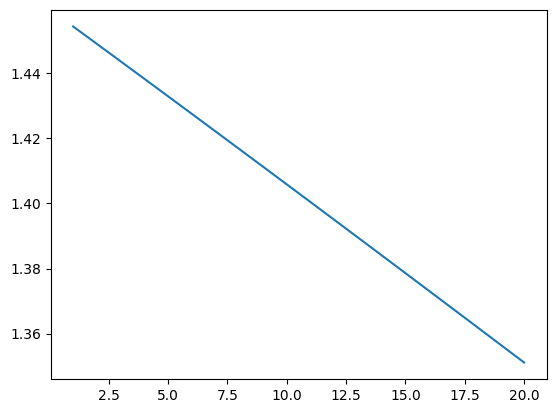

In [18]:
plt.plot(lossx, lossy)

In [23]:
# Fun Visualisation task :)
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot